# Lab

Apologies; this one is hastily constructed.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.datasets import fetch_lfw_people

The faces dataset seems to require the python image library (PIL). Before executing this cell you may need to go to a terminal and type:
```python
conda install PILL -y
```

In [3]:
faces = fetch_lfw_people()

In [8]:
faces.images.shape

(13233, 62, 47)

## Let's preprocess using PCA (this is eigenfaces!)

In [173]:
N, H, W = faces.images.shape
shuffled = arange(len(faces.images))
shuffle(shuffled)
validation_set = shuffled[:100]; shuffled = shuffled[100:]
test_set = shuffled[:100]; shuffled = shuffled[100:]
train_set = shuffled

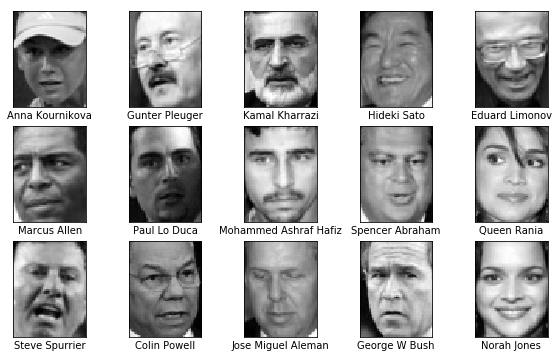

In [174]:
def show_images(images, names, rows, cols):
    for i in range(rows*cols):
        subplot(rows, cols, i+1)
        imshow(images[i], cmap=cm.gray)
        xticks([])
        yticks([])
        xlabel(names[i])
        
figure(figsize=(10,6))        
show_images(faces.images[validation_set], 
            faces.target_names[faces.target[validation_set]],
            3, 5)
        

In [175]:
print N / len(faces.target_names)

2


In [176]:
mu = zeros(W*H)
cov = zeros((W*H, W*H))
for i in range(len(validation_set)):
    im = faces.images[validation_set[i]]
    x = im.flatten()
    cov += outer(x,x)
    mu += x
    print '\r{:3} of {}'.format(i+1, len(validation_set)),
mu /= len(validation_set)
cov /= len(validation_set)
cov -= outer(mu, mu)

100 of 100                                  


In [177]:
variances, components = eigh(cov)
variances = variances[::-1]
components = components.T[::-1]

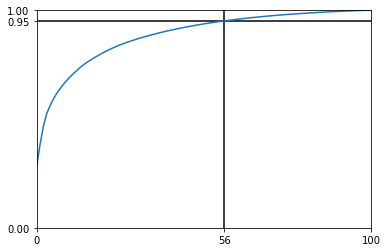

In [178]:
total = sum(variances)
cumvariance = cumsum(variances)/total
threshold = int(argwhere(cumvariance >= 0.95)[0])

plot(cumvariance)
hlines(0.95, 0, len(variances))
vlines(threshold, 0, 1)
xlim(0,  len(validation_set))
ylim(0,1)
yticks([0, .95, 1])
xticks([0, threshold, len(validation_set)]);

In [179]:
component_images = reshape(components[:threshold, ...], (threshold, H, W))
mean_image = reshape(mu, (H, W))

## An interesting experiment
An interesting experiment showed that people generally consider the 'mean' face more attractive than any individual face, is that true here?

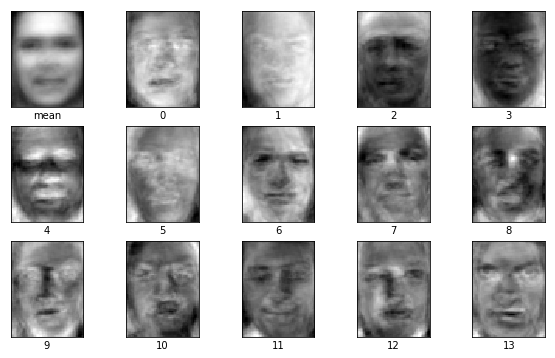

In [180]:
fig = figure(figsize=(10,6))        
show_images([mean_image] + list(component_images), ['mean'] + range(len(component_images)), 3, 5)  

In [181]:
def transform(image):
    x = image.flatten()
    y = components[:threshold].dot(x - mu)/sqrt(variances[:threshold])
    return y

def untransform(y):
    x = components[:threshold].T.dot(y*sqrt(variances[:threshold])) + mu
    return x.reshape(H, W)

The compressed image is 56 numbers


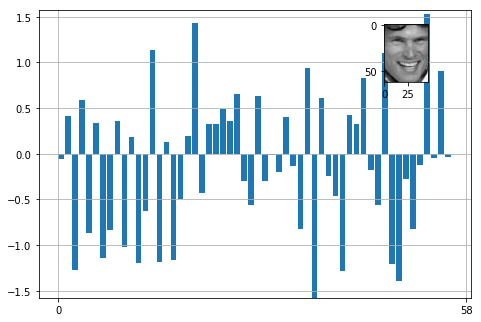

In [182]:
test_index = random.choice(test_set)
test_image = faces.images[test_index]
test_target = faces.target[test_index]

y = transform(test_image)

print "The compressed image is {} numbers".format(len(y))

ax = axes([0, 0, 1, 1])
bar(arange(len(y)), y, align='edge');
ylim(-max(abs(y)), max(abs(y)))
xticks([0, 58])
grid()

ax = axes([0.75, 0.75, 0.2, 0.2])
imshow(test_image, cmap=cm.gray);

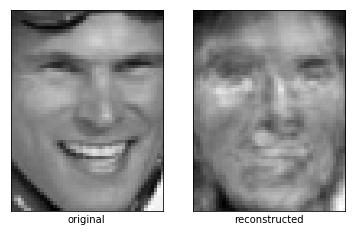

In [183]:
reconstructed_image = untransform(y)

subplot(121)
imshow(test_image, cmap=cm.gray)
xticks([]); yticks([]); xlabel('original')

subplot(122)
imshow(reconstructed_image, cmap=cm.gray)
xticks([]); yticks([]); xlabel('reconstructed');

## Nearest Neighbor

In [184]:
# "training" a nearest neighbor classifier
examples = np.zeros( (len(train_set), threshold) )
for i in range(len(train_set)):
    print "\r{:5} of {}".format(i+1, len(train_set)),
    x = faces.images[train_set[i]]
    y = transform(x)
    examples[i,:] = y

13033 of 13033                                                                             


In [185]:
import heapq

def guess_name(image):
    y = transform(image)
    matches = heapq.nsmallest(5, zip(train_set, examples), lambda item: np.linalg.norm(y - item[1]) )
    results = [index for index, _ in matches]
    return results
        

In [226]:
# Many faces only occur once; I want ones that are in there twice..
train_targets = set(faces.target[train_set])

for t in random.choice(test_set, len(test_set)):
    if faces.target[t] in train_targets:
        test_index = t

In [227]:
#test_index = random.choice(test_set)
test_image = faces.images[test_index]
test_target = faces.target[test_index]

print "Actual name:", faces.target_names[test_target]
print "Guesses:"
guesses = guess_name(test_image)
for guess in guesses:
    print "   ", faces.target_names[faces.target[guess]]

Actual name: Luiz Inacio Lula da Silva
Guesses:
    Joe Gatti
    Zoran Djindjic
    William Hurt
    Roman Polanski
    Walter Mondale


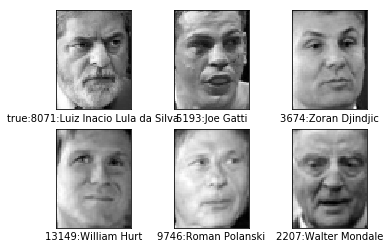

In [228]:
images = [faces.images[idx] for idx in [test_index] + guesses]
labels = ['{}:{}'.format(idx, faces.target_names[faces.target[idx]]) for idx in [test_index] + guesses]
labels[0] = 'true:'+labels[0]
show_images(images, labels, 2, 3)

In [188]:
matches = argwhere(faces.target == faces.target[8966])